In [1]:
import keras
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

import matplotlib.pyplot as plt
import librosa
import librosa.display

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

from keras.layers import Conv2D, MaxPool2D, Activation, Dense, Input, Flatten, BatchNormalization, Dropout
from keras.losses import binary_crossentropy
from keras.optimizers import SGD
from keras.utils import Sequence
import keras.backend as K

import time

%matplotlib inline

Using TensorFlow backend.


In [2]:
checkpoint_dir = './checkpoints_MEL_32f/'

def find_best_checkpoint(prev_chkpts):
    best_ratio = np.inf
    best_chkpt = ''
    best_epoch = 0
    for chkpt in prev_chkpts:
        epoch = int(chkpt[8:11])
        ratio = float(chkpt[12:19])
        
        if ratio < best_ratio:
            best_ratio = ratio
            best_chkpt = chkpt
            best_epoch = epoch
    print('\n starting from model {} \n'.format(best_chkpt))
    return best_chkpt, best_epoch

In [3]:
previous_checkpoints = os.listdir(checkpoint_dir)
best_checkpoint, best_epoch = find_best_checkpoint(previous_checkpoints)
#model.load_weights(checkpoint_dir + best_checkpoint)
model = keras.models.load_model(checkpoint_dir + best_checkpoint)


 starting from model weights-028-0.13129.hdf5 



/home/matteo/anaconda3/envs/NNs/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 909, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 909, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 909, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 454, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 454, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 452, 64)       18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 452, 64)       256       
__________

In [5]:
# this is the placeholder for the input images
input_mel = model.input
input_height = input_mel.shape[1]
input_width = input_mel.shape[2]

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[0:] if 'conv' in layer.name])
layer_dict

{'conv2d_1': <keras.layers.convolutional.Conv2D at 0x7f263ab97128>,
 'conv2d_2': <keras.layers.convolutional.Conv2D at 0x7f263aabf320>,
 'conv2d_3': <keras.layers.convolutional.Conv2D at 0x7f26387ca908>,
 'conv2d_4': <keras.layers.convolutional.Conv2D at 0x7f26383b2ac8>}

In [6]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
#Define the layer for which you want to visualize the 
layer_name = list(layer_dict.keys())[0]
print('Layer {} filter visualization:'.format(layer_name))
filter_no = layer_dict[layer_name].output_shape[3]
print('N° of filters: {}'.format(filter_no))

Layer conv2d_1 filter visualization:
N° of filters: 32


In [ ]:
kept_filters = []

for filter_index in range(filter_no):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_mel)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_mel], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 1, input_height, input_width))
    else:
        input_img_data = np.random.random((1, input_height, input_width, 1))

    # we run gradient ascent for 20 steps
    for i in range(30):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        print('Current loss value:', loss_value)

    kept_filters.append((input_img_data[0,:,:,0], loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

In [ ]:
def plot_max_input_filter(S_db):
    plt.figure(figsize=(20, 6))
    librosa.display.specshow(S_db,
                              y_axis='mel', fmax=8000,
                              x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_max_input_filter(kept_filters[32][0])

In [8]:
import pickle as pk
annotations = pd.read_csv('../data/MagnaTagATune/annotation_reduced_50.csv', sep='\t')
idx = 1
tags = annotations.iloc[idx].values[1:-1]

base_dir = '../data/MagnaTagATune/MEL_default_hop/'
song_path = base_dir + annotations['mp3_path'].iloc[idx][:-3] + 'p'
song = pk.load(open(song_path,'rb'))

In [10]:
conv_layers = [layer.name for layer in model.layers if 'conv' in layer.name]
conv_layers

['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4']

In [11]:
model.input_shape

(None, 128, 911, 1)

In [12]:
y_pred = model.predict(song[np.newaxis,:,:,np.newaxis])

In [13]:
print(np.int32(y_pred > 0.5)[0])
print(tags)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 1 0]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 1 0]


In [14]:
outputs_layers = dict()
for layer in conv_layers:
    intermediate_layer_model = keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer).output)
    outputs_layers[layer] = intermediate_layer_model.predict(song[np.newaxis,:,:,np.newaxis])
    


In [18]:
layer_idx = 3
outputs = outputs_layers[conv_layers[layer_idx]][0,:,:,:]

print('Filters shape: {}'.format(outputs.shape))

Filters shape: (12, 110, 64)


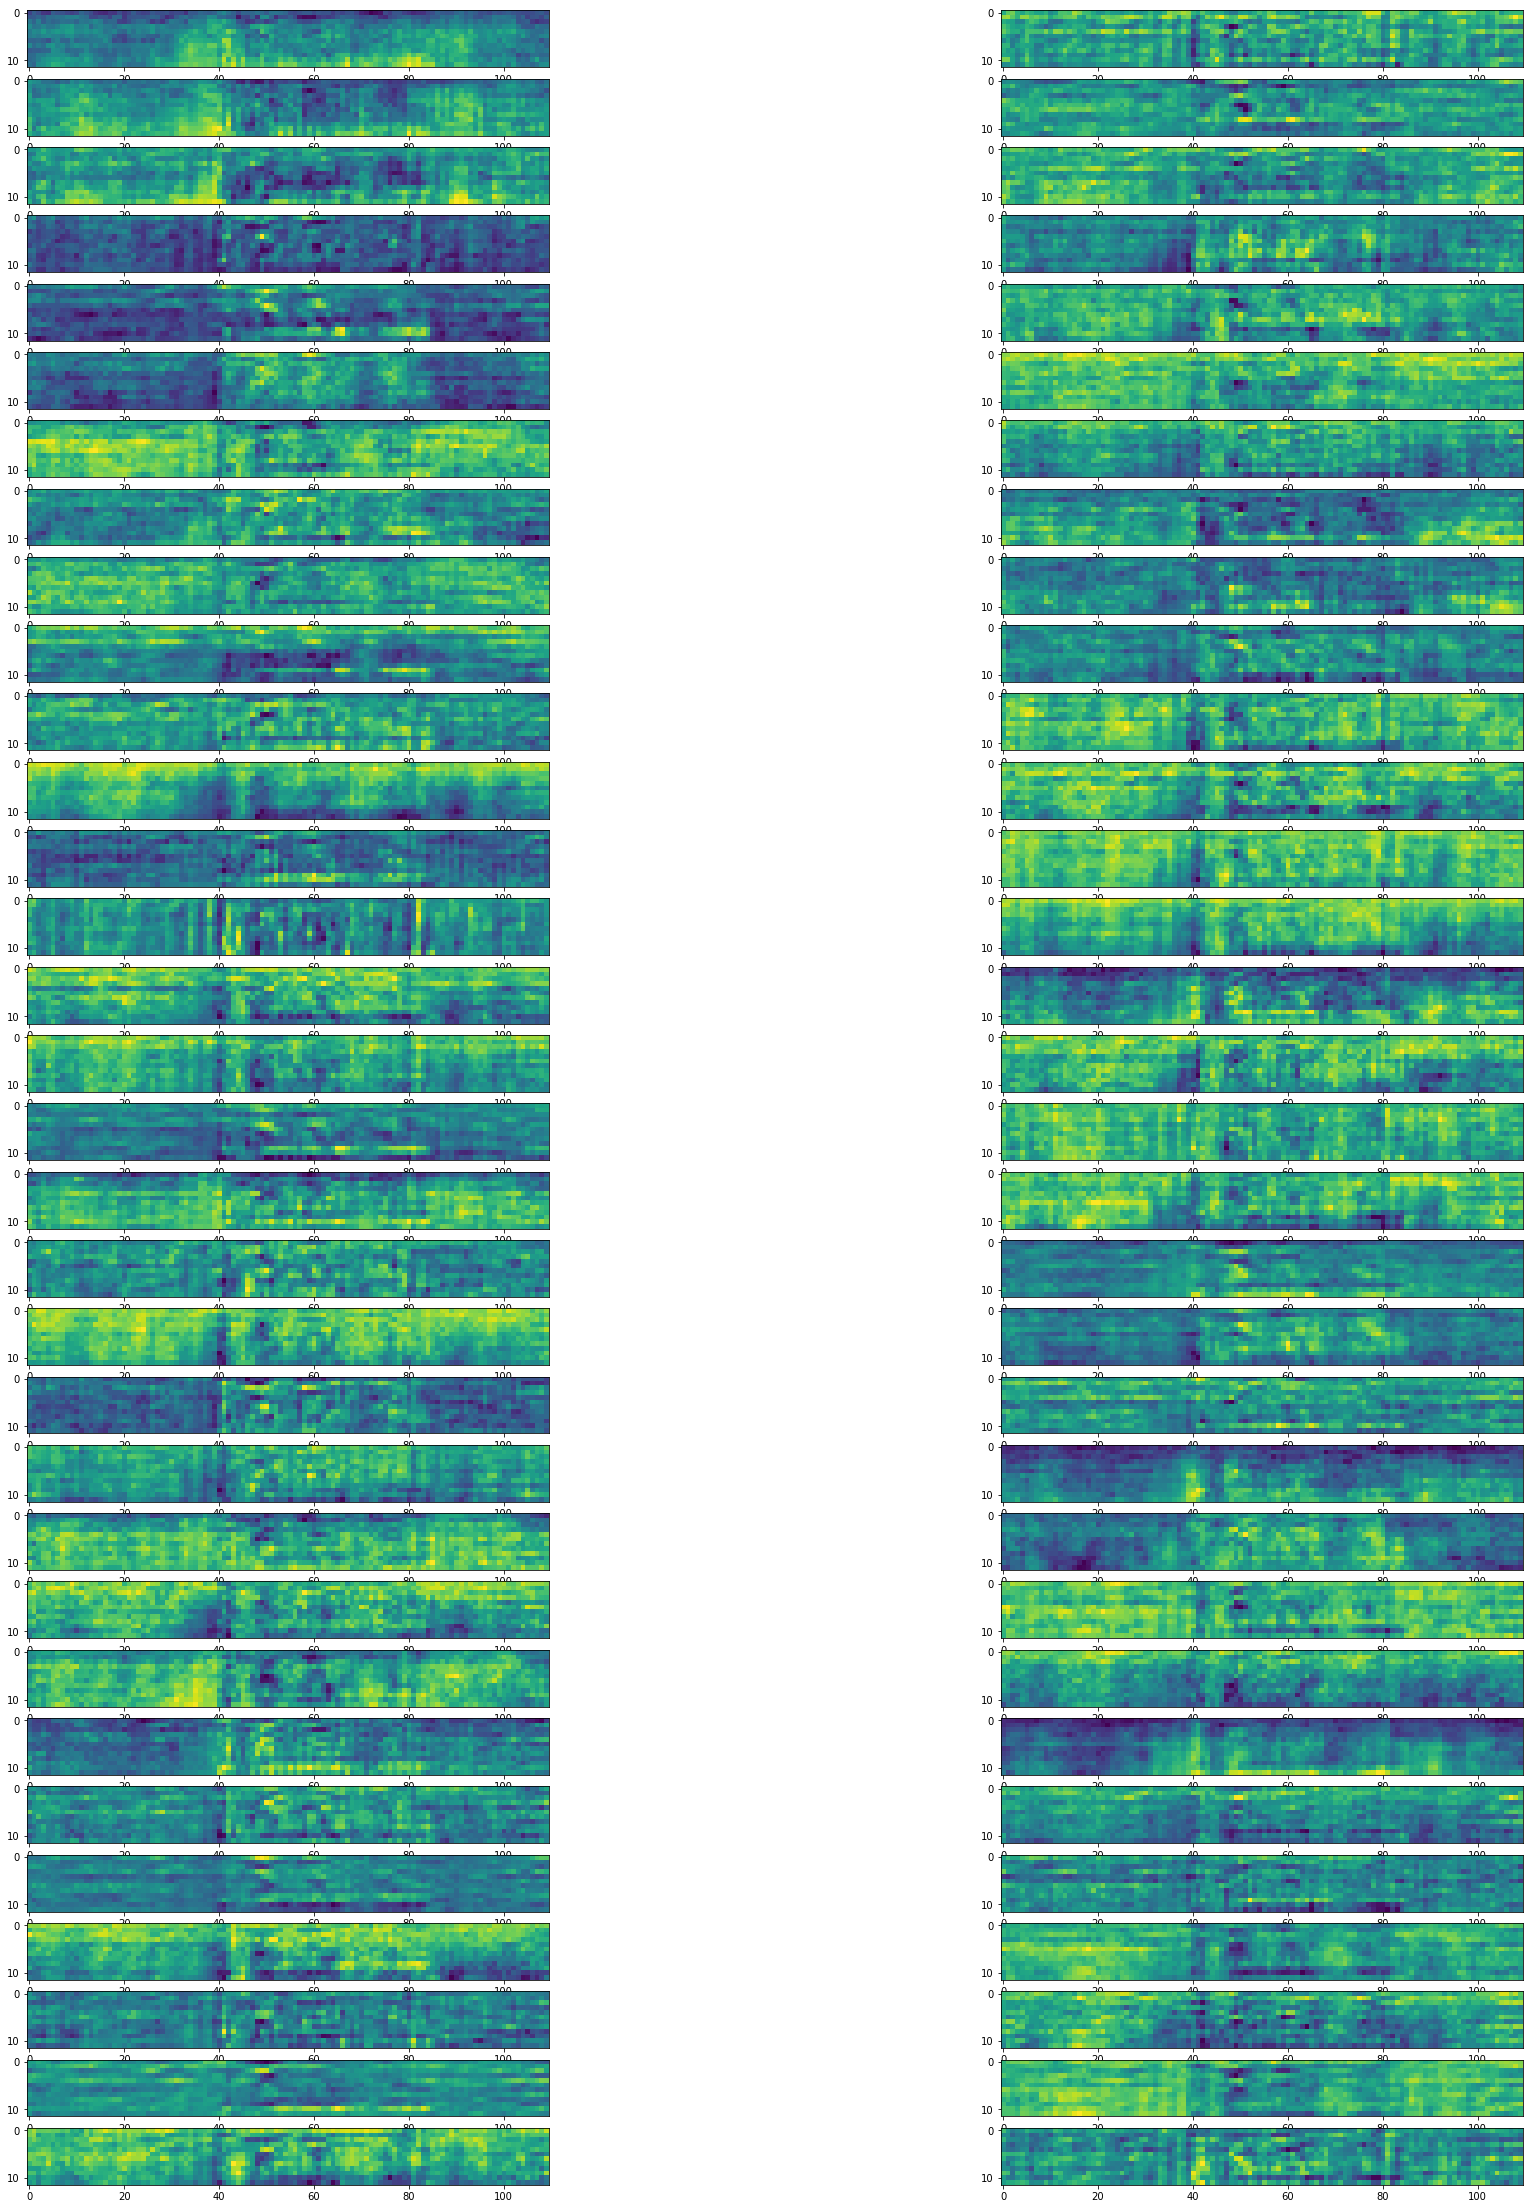

In [19]:
fig, axes = plt.subplots(32,2)
fig.set_size_inches(32,40)
for r_idx,r_ax in enumerate(axes):
    for c_idx, c_ax in enumerate(r_ax):
        c_ax.imshow(outputs[:,:,r_idx*2 + c_idx])

In [16]:
x = np.random.randn(20,20)

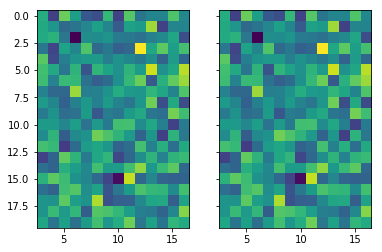

In [17]:
fig, axes = plt.subplots(1, 2, sharey=True)
for a in axes:
    a.imshow(x)

In [ ]:
ax